# In This Notebook we are going to cover Algorithmic Trading
# Trading Strategies Covered
1. Moving Average
2. Mean Reversion using RSI and EMA
3. Breakout Strategy

##Libraries Used:
* NumPy
* Maptplotlib
* Pandas Datareader
* Yahoofinance API
* TA-lib

In [485]:
import math
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf    # Using Yahoo API for Stock Data
yf.pdr_override()

## Data Preperation

In [486]:
ma_1 = 30    # 30 day moving Average
ma_2 = 100   # 100 day moving Average

In [487]:
start = dt.datetime.now() - dt.timedelta(days=365 * 3)     # last 3 years
end = dt.datetime.now()

In [488]:
data = pdr.get_data_yahoo("TSLA",start,end) # Retrieve Stock information of Tesla from Start to End

[*********************100%***********************]  1 of 1 completed


In [489]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-01,57.200001,59.933334,56.939999,59.873333,59.873333,224092500
2020-06-02,59.646667,60.577332,58.066666,58.770668,58.770668,203484000
2020-06-03,59.208000,59.862667,58.673332,58.863998,58.863998,119242500
2020-06-04,59.325333,59.716667,57.229332,57.625332,57.625332,133315500
2020-06-05,58.522667,59.101334,57.746666,59.043999,59.043999,117178500
...,...,...,...,...,...,...
2023-05-24,182.229996,184.220001,178.220001,182.899994,182.899994,137605100
2023-05-25,186.539993,186.779999,180.580002,184.470001,184.470001,96870700
2023-05-26,184.619995,198.600006,184.529999,193.169998,193.169998,161765900


`rolling(window=ma_1).mean()` is a pandas method applied to a pandas Series (in this case, the 'Adj Close' column). It calculates the rolling mean or any other rolling statistic based on the specified window size.

In [490]:
data[f'SMA_{ma_1}'] = data['Adj Close'].rolling(window=ma_1).mean()
data[f'SMA_{ma_2}'] = data['Adj Close'].rolling(window=ma_2).mean()

In [491]:
data = data.iloc[ma_2:] # Start display from ma_2 because up until this point we dont have any moving averages/biased moving average as we dont have 100 days to look back to for ma_2

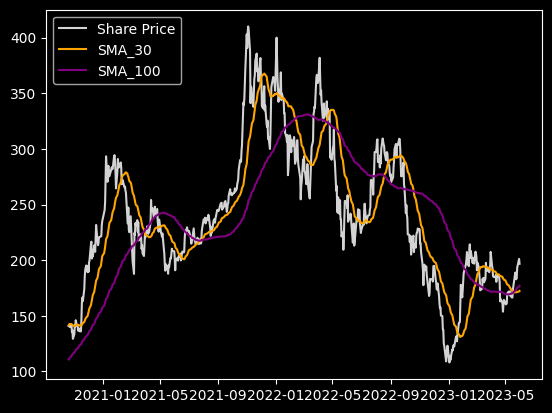

In [492]:
plt.style.use("dark_background")
plt.plot(data['Adj Close'],label = "Share Price", color="lightgray")
plt.plot(data[f'SMA_{ma_1}'],label = f"SMA_{ma_1}", color="orange")
plt.plot(data[f'SMA_{ma_2}'],label = f"SMA_{ma_2}", color="purple")
plt.legend(loc="upper left")
plt.show()

## Implementing Trading Strategy #1
* Buy/Sell when SMA 30 & 100 Cross each other
* Buy = SMA_30 crosses and goes above SMA_100
* Sell = SMA_30 crosses and goes below SMA_100

In [493]:
buy_signals = []
sell_signals = []
trigger = 0 # Change when buy/sell to know what is current state and when are states changed

In [494]:
for x in range (len(data)):
  if data[f'SMA_{ma_1}'].iloc[x] > data[f'SMA_{ma_2}'].iloc[x] and trigger != 1: # if ma_1 > ma_2 and didnt previously buy (1)
    buy_signals.append(data['Adj Close'].iloc[x])
    sell_signals.append(float('nan'))
    trigger = 1
  elif data[f'SMA_{ma_1}'].iloc[x] < data[f'SMA_{ma_2}'].iloc[x] and trigger != -1: # if ma_1 < ma_2 and didnt previously sell (-1)
    buy_signals.append(float('nan'))
    sell_signals.append(data['Adj Close'].iloc[x])
    trigger = -1
  else:
    buy_signals.append(float('nan'))
    sell_signals.append(float('nan'))

In [495]:
data['Buy Signals'] = buy_signals   # Appending new columns to data
data['Sell Signals'] = sell_signals

<ipython-input-495-deecc9786701>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Buy Signals'] = buy_signals   # Appending new columns to data
<ipython-input-495-deecc9786701>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Sell Signals'] = sell_signals


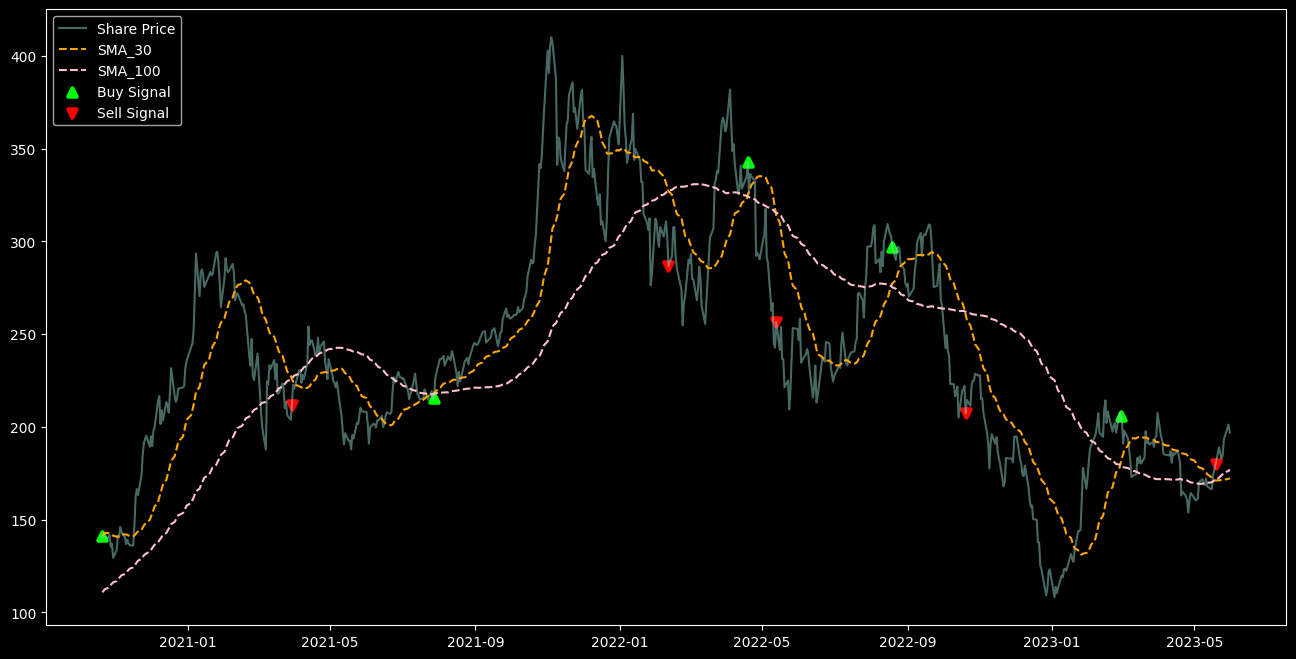

In [496]:
plt.style.use("dark_background")
plt.figure(figsize=(16,8))
plt.plot(data['Adj Close'],label = "Share Price", alpha=0.5)
plt.plot(data[f'SMA_{ma_1}'],label = f"SMA_{ma_1}", color="orange",linestyle="--")
plt.plot(data[f'SMA_{ma_2}'],label = f"SMA_{ma_2}", color="pink",linestyle="--")
plt.scatter(data.index,data['Buy Signals'],label="Buy Signal",marker="^",color="#00ff00",lw=3)
plt.scatter(data.index,data['Sell Signals'],label="Sell Signal",marker="v",color="#ff0000",lw=3)
plt.legend(loc="upper left")
plt.show()

## Findings with Strategy #1

* (Obviously) doesnt always perform well (sometimes profit/loss)
* paramaters for SMA can be adjusted to see different signals
* Is a Technical Analysis trading strategy, no reason to believe it will give good results
* Not just a past prediction, but also a current prediction i.e signals extend to current date

# Strategy #2 Mean Reversion
* Mean Reversion: asset prices and volatility of returns eventually revert to their long-term average levels.
* The return to a normal pattern is not guaranteed, as unexpected highs or lows could indicate a shift in the norm.
* We are going to use RSI to implement Mean Reversion strategy (overbought = 70, Oversold = 30)

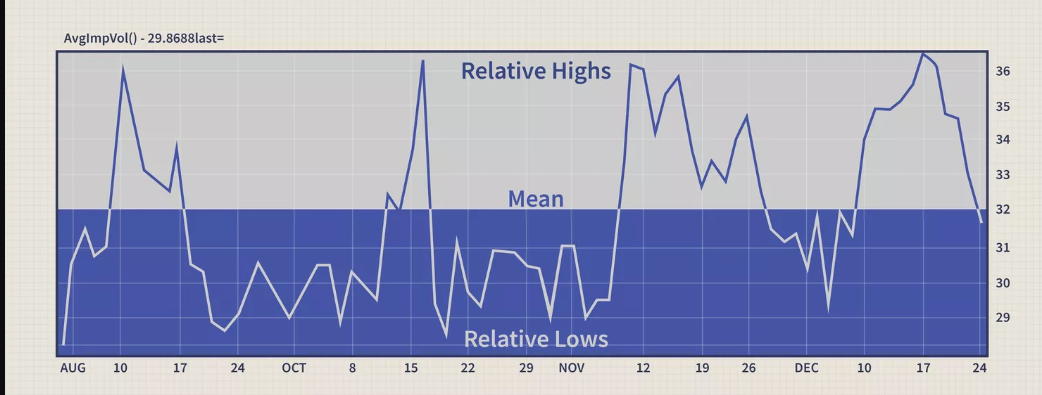

In [497]:
import talib as ta

In [498]:
data = pdr.get_data_yahoo("TSLA",start,end)
data["RSI"] = ta.RSI(data['Close'], timeperiod=14)

[*********************100%***********************]  1 of 1 completed


[Text(0.5, 1.0, 'Relative Strength Index')]

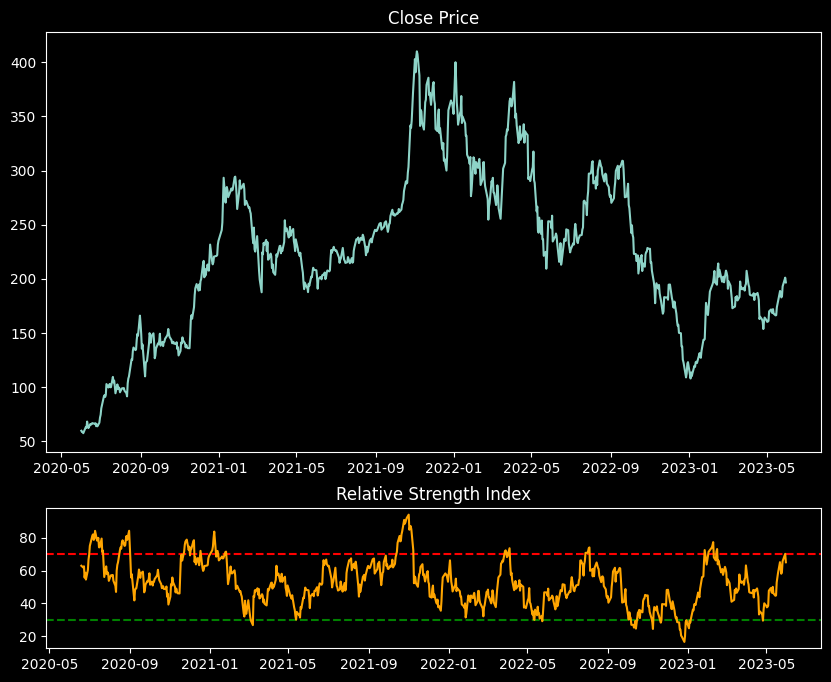

In [499]:
fig,ax = plt.subplots(2,1,gridspec_kw={"height_ratios":[3,1]},figsize=(10,8))

ax[0].plot(data['Close'])
ax[1].axhline(y=70,color="r",linestyle="--") # Usually want to Sell because Overbought
ax[1].axhline(y=30,color="g",linestyle="--") # Usually want to Buy because OverSold
ax[1].plot(data['RSI'],color="orange")
ax[0].set(title="Close Price")
ax[1].set(title="Relative Strength Index")

In [500]:
data["Signal"] = 0 # Initialise a Signal Column
data.loc[data["RSI"] > 70, "Signal"] = -1  # Sell if over Overbought
data.loc[data["RSI"] < 30, "Signal"] = 1 # Buy if Under Oversold

In [501]:
buy_signals = []
sell_signals = []
trigger = 0 # Change when buy/sell to know what is current state and when are states changed

In [502]:
for x in range (len(data)):
  if data["RSI"].iloc[x] < 30 and trigger != 1: # if ma_1 > ma_2 and didnt previously buy (1)
    buy_signals.append(data['Close'].iloc[x])
    sell_signals.append(float('nan'))
    trigger = 1
  elif data["RSI"].iloc[x] > 70 and trigger != -1: # if ma_1 < ma_2 and didnt previously sell (-1)
    buy_signals.append(float('nan'))
    sell_signals.append(data['Close'].iloc[x])
    trigger = -1
  else:
    buy_signals.append(float('nan'))
    sell_signals.append(float('nan'))

In [503]:
data['Buy Signals'] = buy_signals   # Appending new columns to data
data['Sell Signals'] = sell_signals

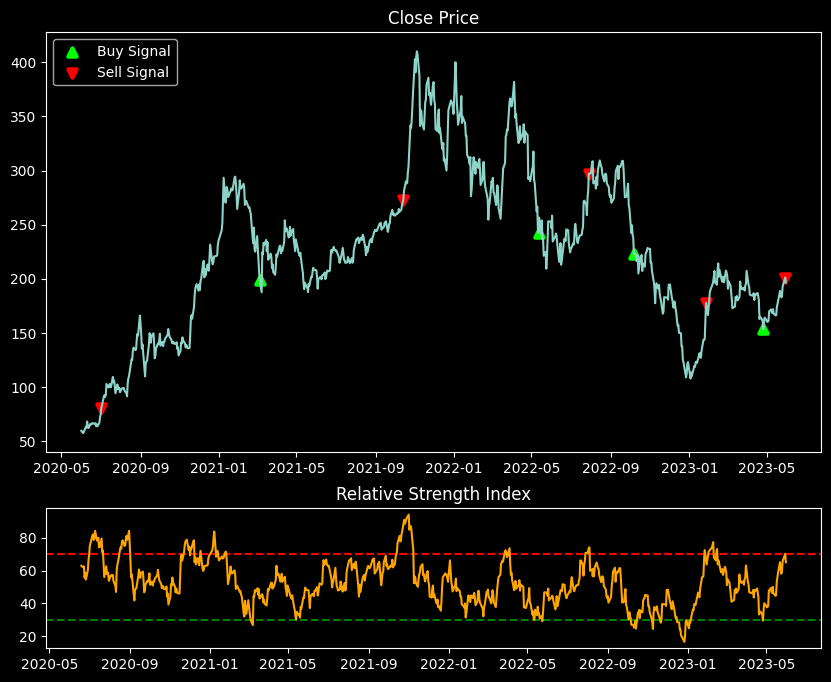

In [504]:
fig,ax = plt.subplots(2,1,gridspec_kw={"height_ratios":[3,1]},figsize=(10,8))

ax[0].plot(data['Close'])
ax[1].axhline(y=70,color="r",linestyle="--") # Usually want to Sell because Overbought
ax[1].axhline(y=30,color="g",linestyle="--") # Usually want to Buy because OverSold
ax[1].plot(data['RSI'],color="orange")
ax[0].set(title="Close Price")
ax[1].set(title="Relative Strength Index")
ax[0].scatter(data.index,data['Buy Signals'],label="Buy Signal",marker="^",color="#00ff00",lw=3)
ax[0].scatter(data.index,data['Sell Signals'],label="Sell Signal",marker="v",color="#ff0000",lw=3)
ax[0].legend(loc="upper left")


## Strategy 2.5 Mean Reversion using EMA
* Timeperiod = 100

In [505]:
data['EMA_100'] = ta.EMA(data['Close'],100)

In [506]:
mean_value = data['EMA_100'].mean()
upper_threshold = mean_value + 2  # Example: 2 standard deviations above the mean
lower_threshold = mean_value - 2  # Example: 2 standard deviations below the mean


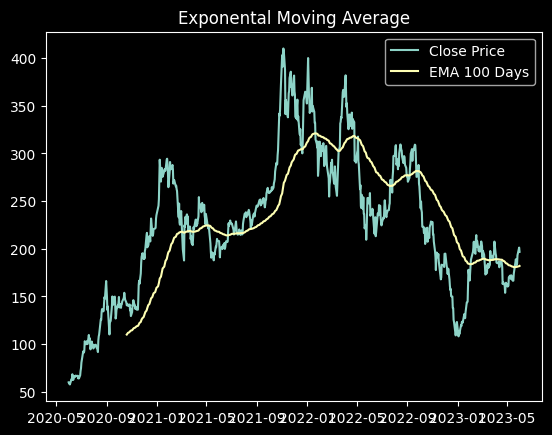

In [507]:
plt.plot(data['Close'], label="Close Price")
plt.plot(data['EMA_100'], label="EMA 100 Days")
plt.title("Exponental Moving Average")
plt.legend()

In [508]:
buy_signals = []
sell_signals = []
trigger = 0 # Change when buy/sell to know what is current state and when are states changed

In [509]:
data = data.iloc[100:]

In [510]:
for x in range (len(data)):
  if data["Close"].iloc[x] < lower_threshold and trigger != 1: # if close is below threshold and didnt previously buy (1)
    buy_signals.append(data['Close'].iloc[x])
    sell_signals.append(float('nan'))
    trigger = 1
  elif data["Close"].iloc[x] > upper_threshold and trigger != -1: # if close is above threshold and didnt previously sell (-1)
    buy_signals.append(float('nan'))
    sell_signals.append(data['Close'].iloc[x])
    trigger = -1
  else:
    buy_signals.append(float('nan'))
    sell_signals.append(float('nan'))

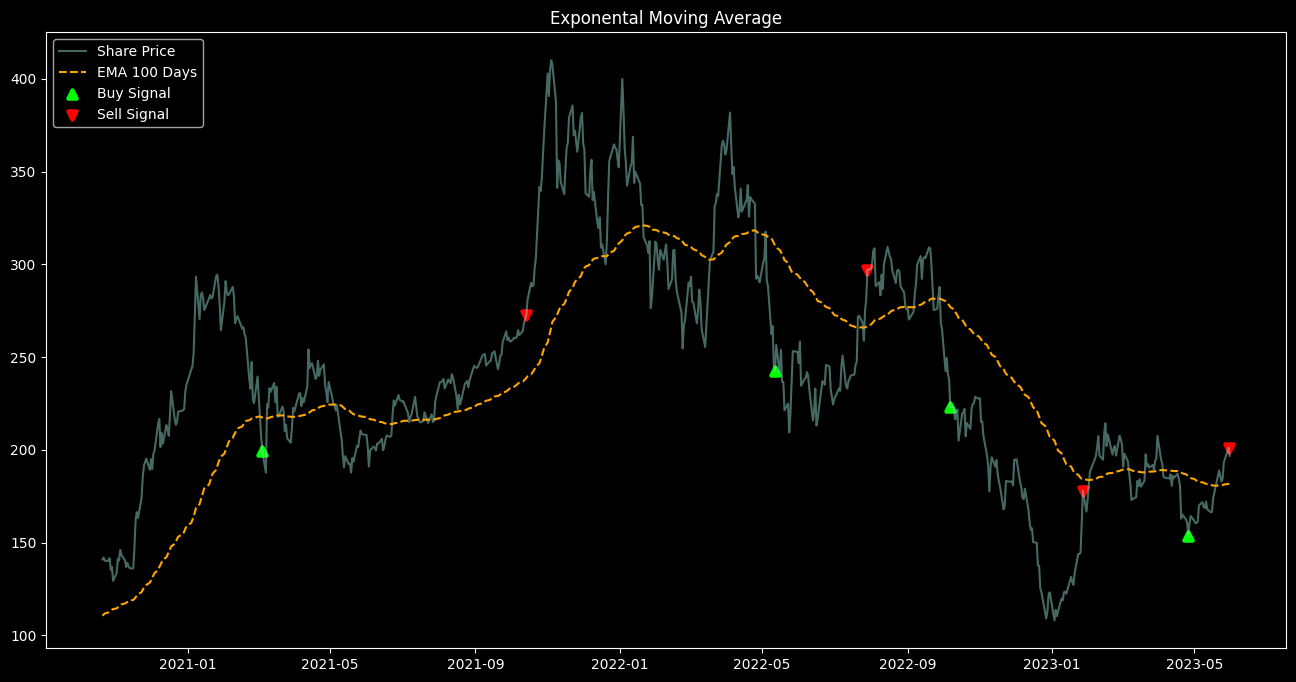

In [511]:
plt.style.use("dark_background")
plt.figure(figsize=(16,8))
plt.plot(data['Close'],label = "Share Price", alpha=0.5)
plt.plot(data['EMA_100'], label="EMA 100 Days", color="orange",linestyle="--")
plt.scatter(data.index,data['Buy Signals'],label="Buy Signal",marker="^",color="#00ff00",lw=3)
plt.scatter(data.index,data['Sell Signals'],label="Sell Signal",marker="v",color="#ff0000",lw=3)
plt.legend(loc="upper left")
plt.title("Exponental Moving Average")
plt.show()

# Strategy #3 Breakout Strategy
* This strategy looks for levels or areas that a security has been unable to move beyond, and waits for it to move beyond those levels 
* A breakout trader looks for price, a technical indicator, or a data point to move beyond a support or resistance level.

Using .max() calculates the highest value within the specified window, which represents the peak or maximum price observed within that period. This approach focuses on identifying significant breakouts where the price exceeds previous highs. It tends to generate buy signals when the price breaks above strong resistance levels.

In [512]:
data = pdr.get_data_yahoo("MSFT",start,end) # Retrieve Stock information of Tesla from Start to End

[*********************100%***********************]  1 of 1 completed


In [513]:
# Define breakout criteria
data["Breakout Threshold"] = data["Close"].rolling(window=20).max() - 1 # Example: relaxed breakout above of 20-day high

In [514]:
buy_signals = []
sell_signals = []
trigger = 0 # Change when buy/sell to know what is current state and when are states changed

In [515]:
for x in range (len(data)):
  if data["Close"].iloc[x] > data["Breakout Threshold"].iloc[x]: # if close is above Breakout Threshold, Buy
    buy_signals.append(data['Close'].iloc[x])  
  else:
    buy_signals.append(float('nan'))
data['Buy Signals'] = buy_signals   # Appending new columns to data

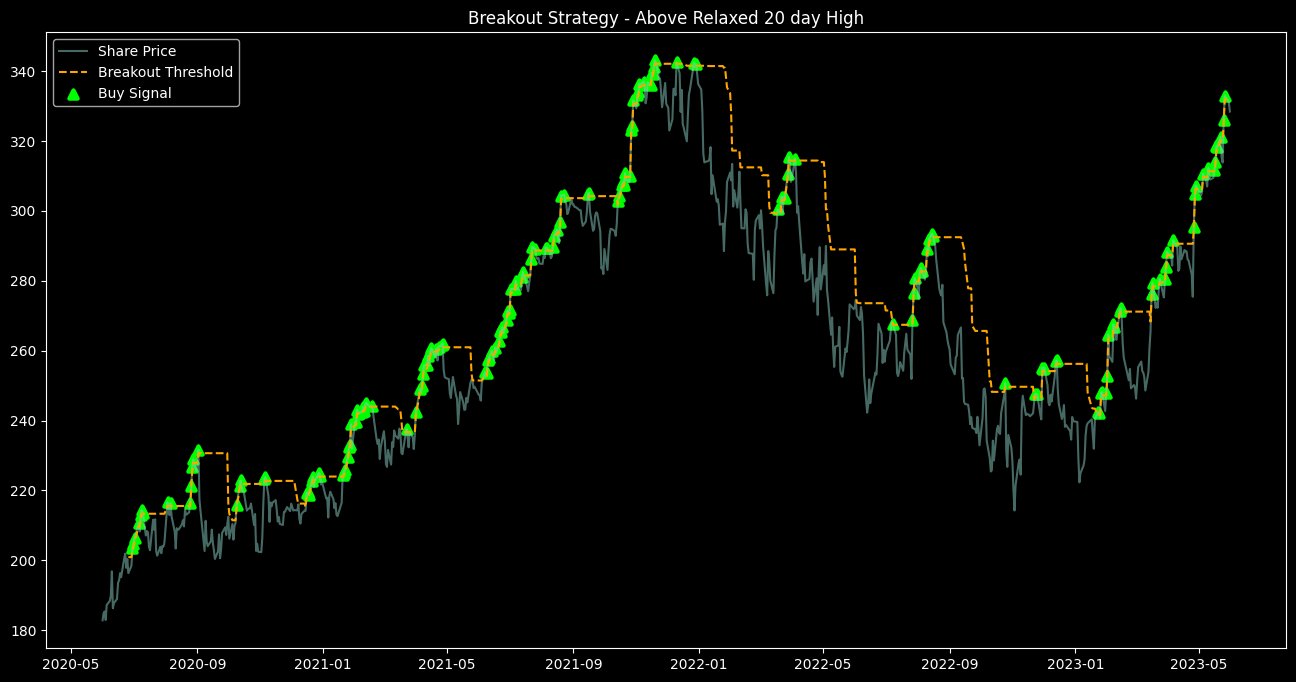

In [516]:
plt.style.use("dark_background")
plt.figure(figsize=(16,8))
plt.plot(data['Close'],label = "Share Price", alpha=0.5)
plt.plot(data['Breakout Threshold'], label="Breakout Threshold", color="orange",linestyle="--")
plt.scatter(data.index,data['Buy Signals'],label="Buy Signal",marker="^",color="#00ff00",lw=3)
plt.title("Breakout Strategy - Above Relaxed 20 day High")
plt.legend(loc="upper left")
plt.show()